Imports:

In [3]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
print(train_df.head())
print(train_df.shape)

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
(120000, 3)


In [5]:
print(train_df.columns)
print(train_df["Class Index"].value_counts())

Index(['Class Index', 'Title', 'Description'], dtype='object')
Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


In [6]:
train_df["text"]=train_df["Title"]+ " " +train_df["Description"]
test_df["text"]=test_df["Title"]+ " " +test_df["Description"]
train_df["label"]=train_df["Class Index"]-1
test_df["label"]=test_df["Class Index"]-1
train_df=train_df[["text","label"]]
test_df=test_df[["text","label"]]
print(train_df.head())


                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


In [7]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())


text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
0
0


In [8]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [9]:
def decontract_words(text):
    text=text.split()
    new_text=[]
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    return " ".join(new_text)

In [10]:
def format_text_regex(text):
    text=re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text=re.sub(r'\<a href', ' ', text) #clean html style URL
    text=re.sub(r'&amp;', '', text) #remove &amp; chars
    text=re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text=re.sub(r'<br />', ' ', text)
    text=re.sub(r'\'', ' ', text)
    return text

In [11]:
def clean_text(text):
    text=text.lower()
    text=decontract_words(text)
    text=format_text_regex(text)
    text=nltk.WordPunctTokenizer().tokenize(text)
    return text

In [12]:
train_df["tokens"]=train_df["text"].apply(clean_text)
test_df["tokens"]=test_df["text"].apply(clean_text)
print(train_df["tokens"].iloc[0])
print(train_df.head())

['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', '\\', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again']
                                                text  label  \
0  Wall St. Bears Claw Back Into the Black (Reute...      2   
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   
4  Oil prices soar to all-time record, posing new...      2   

                                              tokens  
0  [wall, st, bears, claw, back, into, the, black...  
1  [carlyle, looks, toward, commercial, aerospace...  
2  [oil, and, economy, cloud, stocks, outlook, re...  
3  [iraq, halts, oil, exports, from, main, southe...  
4  [oil, prices, soar, to, all, time, record, pos...  


In [13]:
counter=Counter()

for tokens in train_df["tokens"]:
    counter.update(tokens)

print(len(counter))

64766


In [14]:
vocab_size=30000
most_common=counter.most_common(vocab_size)
word2idx={"PAD":0,"UNK":1}
for i,(word,_) in enumerate(most_common):
    word2idx[word]=i+2
print("Vocab size:",len(word2idx))
print(list(word2idx.items()))

Vocab size: 30002
[('PAD', 0), ('UNK', 1), ('the', 2), ('to', 3), ('a', 4), ('of', 5), ('in', 6), ('and', 7), ('s', 8), ('on', 9), ('for', 10), ('39', 11), ('that', 12), ('with', 13), ('as', 14), ('at', 15), ('\\', 16), ('is', 17), ('new', 18), ('its', 19), ('by', 20), ('it', 21), ('said', 22), ('has', 23), ('from', 24), ('reuters', 25), ('an', 26), ('ap', 27), ('will', 28), ('his', 29), ('after', 30), ('was', 31), ('us', 32), ('be', 33), ('have', 34), ('over', 35), ('up', 36), ('lt', 37), ('their', 38), ('two', 39), ('are', 40), ('first', 41), ('quot', 42), ('year', 43), ('but', 44), ('more', 45), ('he', 46), ('gt', 47), ('not', 48), ('world', 49), ('this', 50), ('u', 51), ('one', 52), ('1', 53), ('out', 54), ('oil', 55), ('company', 56), ('monday', 57), ('wednesday', 58), ('tuesday', 59), ('thursday', 60), ('2', 61), ('against', 62), ('inc', 63), ('friday', 64), ('into', 65), ('than', 66), ('last', 67), ('they', 68), ('iraq', 69), ('about', 70), ('b', 71), ('york', 72), ('yesterday',

In [15]:
def encode_tokens(tokens, word2idx):
    return [word2idx.get(word, word2idx["UNK"]) for word in tokens]
train_df["encoded"]=train_df["tokens"].apply(lambda x:encode_tokens(x,word2idx))
test_df["encoded"]=test_df["tokens"].apply(lambda x:encode_tokens(x,word2idx))
print(train_df["encoded"].iloc[0])


[475, 441, 1625, 14673, 106, 65, 2, 847, 25, 25, 759, 8052, 475, 404, 8, 10038, 16, 2867, 5, 5723, 25206, 40, 4031, 777, 329]


In [16]:
lengths=train_df["encoded"].apply(len)
print(lengths.describe())


count    120000.000000
mean         39.103475
std          10.966897
min           4.000000
25%          33.000000
50%          39.000000
75%          45.000000
max         181.000000
Name: encoded, dtype: float64


In [17]:
max_len=int(lengths.quantile(0.95))
def pad_sequence(seq, max_len):
    if len(seq)<max_len:
        return seq+[0]*(max_len-len(seq))
    else:
        return seq[:max_len]


In [18]:
train_df["padded"]=train_df["encoded"].apply(lambda x:pad_sequence(x,max_len))
test_df["padded"]=test_df["encoded"].apply(lambda x:pad_sequence(x,max_len))
print(len(train_df["padded"].iloc[0]))

56


In [19]:
X_train=torch.tensor(train_df["padded"].tolist(),dtype=torch.long)
y_train=torch.tensor(train_df["label"].tolist(),dtype=torch.long)
X_test=torch.tensor(test_df["padded"].tolist(),dtype=torch.long)
y_test=torch.tensor(test_df["label"].tolist(),dtype=torch.long)
print(X_train.shape, y_train.shape)

torch.Size([120000, 56]) torch.Size([120000])


In [20]:
X_train_split,X_val,y_train_split,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify=y_train)
batch_size = 64
train_loader=DataLoader(TensorDataset(X_train_split,y_train_split),batch_size=batch_size,shuffle=True)
val_loader=DataLoader(TensorDataset(X_val,y_val),batch_size=batch_size,shuffle=False)
test_loader=DataLoader(TensorDataset(X_test,y_test),batch_size=batch_size,shuffle=False)

In [21]:
import torch

def evaluate(model,loader,criterion,device):
    model.eval()
    total_loss,correct,total=0.0, 0, 0
    with torch.no_grad():
        for X,y in loader:
            X,y=X.to(device),y.to(device)
            logits=model(X)
            loss=criterion(logits,y)
            total_loss+=loss.item()*X.size(0)
            preds=logits.argmax(dim=1)
            correct+=(preds==y).sum().item()
            total+=y.size(0)
    return total_loss/total,correct/total


In [22]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size,embed_dim,hidden_dim,num_classes,pad_idx=0,dropout=0.5):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru=nn.GRU(embed_dim,hidden_dim,batch_first=True)
        self.dropout=nn.Dropout(dropout)
        self.fc=nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x=self.embedding(x)
        out,h=self.gru(x)
        h_last=self.dropout(h[-1])
        logits=self.fc(h[-1])
        return logits


In [23]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size=len(word2idx)
num_classes=train_df["label"].nunique()

model=GRUClassifier(vocab_size=vocab_size,embed_dim=128,hidden_dim=64,num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)


In [24]:
def train_one_epoch(model,loader,criterion,optimizer,device,epoch_idx=1,num_epochs=1):
    model.train()
    total_loss,correct,total=0.0,0,0
    pbar=tqdm(loader,desc=f"Epoch{epoch_idx}/{num_epochs}",leave=False)
    for X,y in pbar:
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        logits=model(X)
        loss=criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()*X.size(0)
        preds=logits.argmax(dim=1)
        correct+=(preds==y).sum().item()
        total+=y.size(0)
        pbar.set_postfix(loss=total_loss/total,acc=correct/total)
    return total_loss / total, correct / total

In [25]:
num_epochs = 5
history = {"train_loss": [], "train_acc": [],"val_loss": [], "val_acc": []}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device,epoch_idx=epoch, num_epochs=num_epochs)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch}/{num_epochs} | "f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "f"Val: loss={val_loss:.4f}, acc={val_acc:.4f}")


Epoch1/5:   0%|          | 0/1688 [00:00<?, ?it/s]

Epoch 1/5 | Train: loss=0.7059, acc=0.6833 | Val: loss=0.3322, acc=0.8890


Epoch2/5:   0%|          | 0/1688 [00:00<?, ?it/s]

Epoch 2/5 | Train: loss=0.2837, acc=0.9061 | Val: loss=0.2720, acc=0.9113


Epoch3/5:   0%|          | 0/1688 [00:00<?, ?it/s]

Epoch 3/5 | Train: loss=0.2388, acc=0.9199 | Val: loss=0.2455, acc=0.9182


Epoch4/5:   0%|          | 0/1688 [00:00<?, ?it/s]

Epoch 4/5 | Train: loss=0.2172, acc=0.9264 | Val: loss=0.2383, acc=0.9202


Epoch5/5:   0%|          | 0/1688 [00:00<?, ?it/s]

Epoch 5/5 | Train: loss=0.2011, acc=0.9310 | Val: loss=0.2355, acc=0.9219


In [26]:
test_loss, test_acc = evaluate(model, test_loader,criterion,device)
print(f"FINAL TEST | loss={test_loss:.4f}, acc={test_acc:.4f}")


FINAL TEST | loss=0.2510, acc=0.9157


In [27]:
def get_predictions(model,loader,device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X,y in loader:
            X=X.to(device)
            logits=model(X)
            preds=logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    return all_labels, all_preds


              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1900
           1       0.95      0.98      0.97      1900
           2       0.89      0.89      0.89      1900
           3       0.88      0.91      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



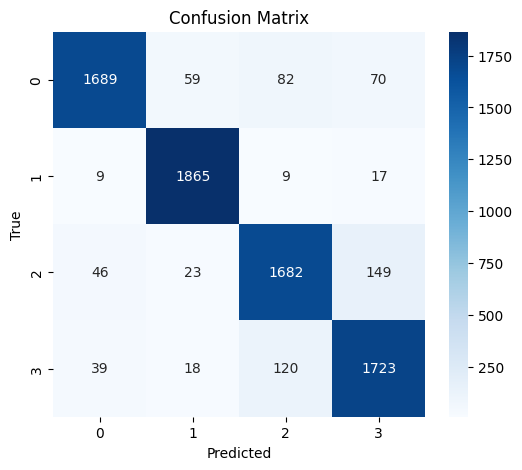

[[1689   59   82   70]
 [   9 1865    9   17]
 [  46   23 1682  149]
 [  39   18  120 1723]]


In [28]:
y_true,y_pred=get_predictions(model,test_loader,device)
cm=confusion_matrix(y_true,y_pred)
print(classification_report(y_true,y_pred))
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print(cm)

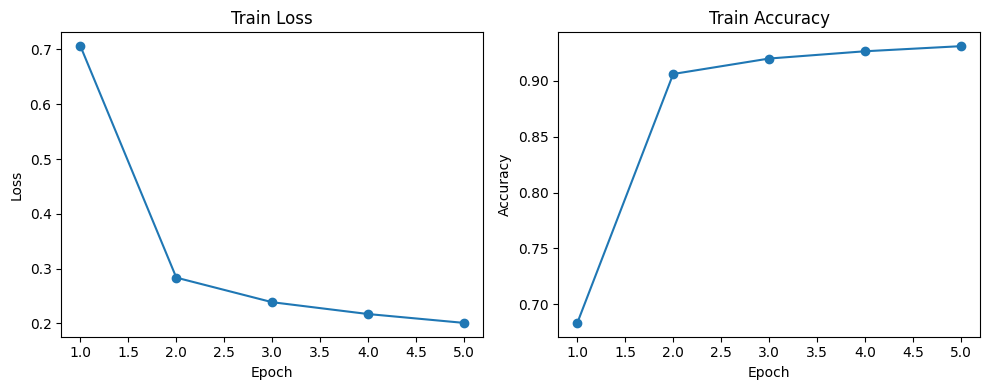

In [29]:
epochs = range(1, len(history["train_loss"])+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs,history["train_loss"],marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(epochs,history["train_acc"],marker='o')
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

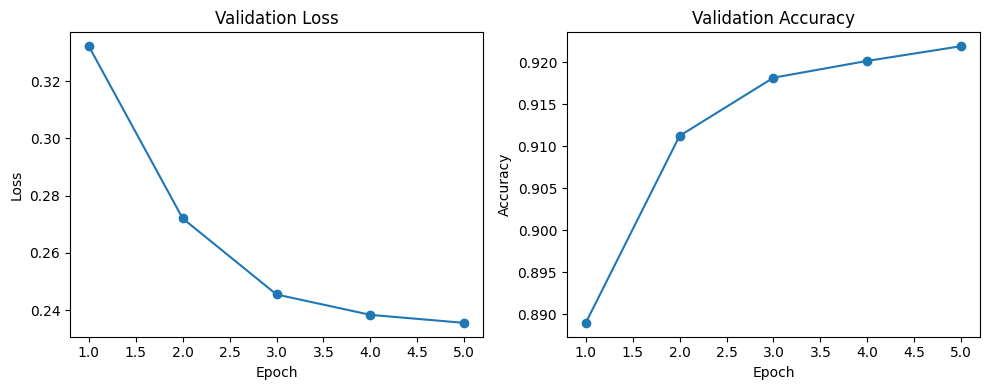

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["val_loss"], marker='o')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(epochs, history["val_acc"], marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()